In [1]:
import pandas as pd
import clean
from faker import Faker
from workers import Worker

### Cleaning the dataset
* Step 1: Import excel sheets 
* Step 2: Remove redundant col names from Worker df (Shift Start Date, Shift End Date)
* Step 3: Merged Unfufiled and filled dataframes together, labeling "Worker ID" for the unfulfilled shifts as "unfulfilled"
* Step 4: Created a shift length col for Shift df
* Step 5: Added in a Role classification col for both dfs (NP, CC, Scribe)
* Step 6: Imputed missing preferred hours in worker df using: (actual hours worked / 4 weeks)
* Step 7: Return cleaned dfs: Workers, Shifts

*View clean.py for a detailed walkthrough of how the datasets were cleaned*

In [2]:
workers, shifts = clean.clean_shifts()

### Issue 2: Scheduling and Misused hours
##### Insights
* Out of the 17 workers that did not work any hours last month, 3 did have preferred hours specified, 2 have no position specified, the rest had no preferred hours specified
* There were 13 workers who worked more than there specified preferred hours (see pivot chart for breakdown by Role)
* All roles saw an abundance of unused hours (>1000) by the end of the month leading us to wonder why are there still significant unfulfilled shifts

In [3]:
# Investigate overutilized workers, i.e., actual hours worked > preferred hours worked
workers['Hour Delta'] = workers['Preferred Hours'] - workers['Actual Hours']

# Filtering df for a negative delta hours 
over_utilized = workers[workers['Hour Delta'] < 0]

# Over utilized hours do not seem significant - additionally only two workers who had preferred hours of 40 (full-time) ended up working overtime.
over_utilized.groupby('Role')['Hour Delta'].sum()

Role
CC       -10.0
NP       -51.0
Scribe    -8.0
Name: Hour Delta, dtype: float64

In [4]:
# Investigate underutilized workers, i.e. actual hours worked < preferred hours worked

total_hours = workers.groupby('Role')['Preferred Hours'].sum()
unutilized = workers[workers['Hour Delta'] > 0]
unutilized = unutilized.groupby('Role')['Hour Delta'].sum()
unfulfilled = shifts[shifts['Worker ID'] == 'unfulfilled'].groupby('Role')['Shift Length'].sum()
fufilled = shifts[shifts['Worker ID'] != 'unfulfilled'].groupby('Role')['Shift Length'].sum()

chart = pd.concat([total_hours,unutilized,fufilled, unfulfilled],axis=1, keys=['Total Hours Provided','Unutilized Hours','Fufilled Hours', 'unfulfilled Hours'])
chart['Unutilized Hours'] = chart['Unutilized Hours']*4
chart['Total Hours Provided'] = chart['Total Hours Provided']*4
chart

,Total Hours Provided,Unutilized Hours,Fufilled Hours,unfulfilled Hours
Role,,,,
CC,6984.0,2380.0,4998,210
NP,3328.0,1012.0,2576,352
Scribe,3088.0,1104.0,2842,56


***

##### Running the newly created Schedule Builder to identify workers who would have been available and qualified to work durring the unfulfilled shifts
##### Process
* Using a newly created Worker object, we will create a programmatic representation of each worker, their information, as well as all the shifts they actually worked last month
* Thereafter, we will test each shift on each worker to see how many workers would have been both qualified and 'available' to work that shift; after one qualified worker will be selected at random to fufill the shift, and the process will continue with the next shift and so on.

In [5]:
# Instantiate Faker as fake
fake = Faker()

In [6]:
Forward_staff = []

for index, row in workers.iterrows():
    first_name = fake.first_name()
    worker = Worker(first_name, row['Worker ID'], row['Positions'], row['Preferred Hours'])
    Forward_staff.append(worker)

In [7]:
# Recreating seperate dfs for unfulfilled and fufilled shifts
fufilled_shifts_df = shifts[shifts['Worker ID'] !='unfulfilled'].reset_index(drop=True)
unfulfilled_shifts_df = shifts[shifts['Worker ID'] =='unfulfilled'].reset_index(drop=True)

In [8]:
for index, row in fufilled_shifts_df.iterrows():
    for worker in Forward_staff:
        if worker.worker_ID == row['Worker ID']:
            shift = [row['Shift Start Time'], row['Shift End Time']]
            worker.add_shift(shift, row['Shift Length'])

In [9]:
import random

unfulfilled_shifts = {}

# First Iterate through each row or shift 
for index, row in unfulfilled_shifts_df.iterrows():
    possible_workers = []
    # Second iterate through each worker to compare the matching criteria 
    for worker in Forward_staff:
        if worker.is_free(row['Shift Start Time'], row['Shift End Time']) and worker.meets_preferred_hours(row['Shift Length']) and worker.is_qualified(row['Positions']):
            possible_workers.append(worker)


    # Conditional to test if there were any matching workers identified
    if possible_workers:
        unfulfilled_shifts[row['Positions'] + " shift on " + row['Shift Start Time'].strftime('%m-%d, %H:%M')] = len(possible_workers)
        # Select worker at random from list
        selected_worker = random.choice(possible_workers)
        # Assign selected worker to shift
        unfulfilled_shifts_df.at[index,'Worker ID'] = selected_worker.worker_ID
        selected_worker.add_shift([row['Shift Start Time'],row['Shift End Time']],row['Shift Length'])

In [10]:
df_unfulfilled_shifts = pd.DataFrame.from_dict(unfulfilled_shifts, orient='index', columns=['Num Possible Workers'])
df_unfulfilled_shifts.reset_index(inplace=True)
df_unfulfilled_shifts = df_unfulfilled_shifts.rename(columns={'index': 'Positions'})
df_unfulfilled_shifts = clean.Role_classification(df_unfulfilled_shifts)

In [11]:
df_unfulfilled_shifts

,Positions,Num Possible Workers,Role
0,"NP NY shift on 07-27, 18:00",15,NP
1,"NP CA shift on 07-27, 13:30",19,NP
2,"NP NY shift on 07-27, 13:30",17,NP
3,"NP NY shift on 07-27, 12:00",16,NP
4,"NP CA shift on 07-27, 12:00",18,NP
...,...,...,...
260,"NP CA+NY+DC shift on 06-30, 10:30",7,NP
261,"NP CA shift on 06-30, 10:30",12,NP
262,"NP CA shift on 06-30, 09:00",14,NP
263,"NP CA+NY+DC shift on 06-30, 09:00",8,NP


C:\Users\A654219\AppData\Local\Temp\ipykernel_36728\3356376208.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_unfulfilled_shifts, x='Role', y='Num Possible Workers', palette=['lightsteelblue', 'darkseagreen', 'moccasin'], ax=ax)


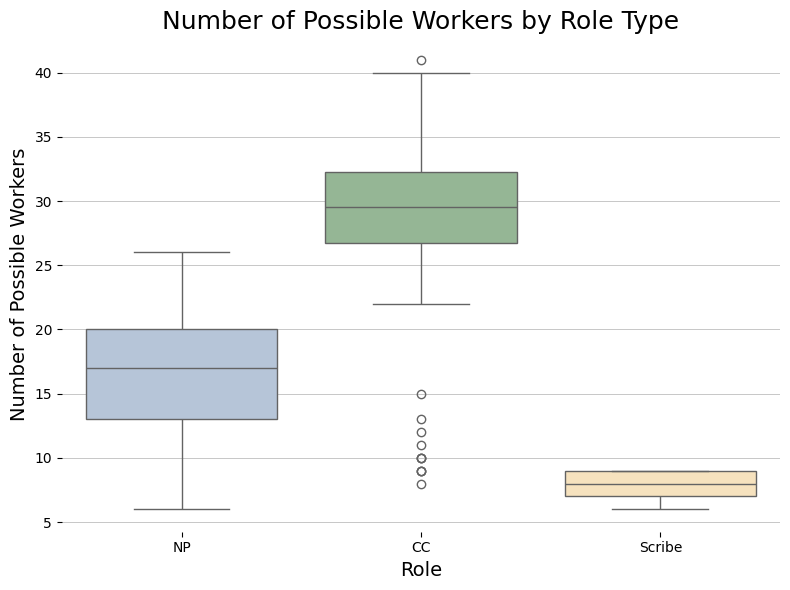

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_unfulfilled_shifts, x='Role', y='Num Possible Workers', palette=['lightsteelblue', 'darkseagreen', 'moccasin'], ax=ax)
ax.set_title('Number of Possible Workers by Role Type', fontsize = 18)
ax.set_xlabel('Role', fontsize = 14)
ax.set_ylabel('Number of Possible Workers', fontsize = 14)
plt.tight_layout()

# Remove the spines (boxes around the chart)
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)
plt.grid(axis='y', linewidth=0.5)
# Save the plot
# plt.savefig('boxplot.png', dpi=300)

# Optionally, show the plot
plt.show()